<a href="https://colab.research.google.com/github/pmontecinos23/Grocery-Store-Sales-Predictions/blob/main/Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grocery Sales Predictions
Paul Montecinos

## Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Regression Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn import set_config
set_config(display='diagram')

In [3]:
# Create function printing vaules using multiple metrics for models
def modtics(pipe, x_train, y_train, x_test, y_test,
            model_name = 'Regression Model',):
  # Train
  r2 = r2_score(y_train, pipe.predict(x_train))
  rmse = np.sqrt(mean_squared_error(y_train, pipe.predict(x_train)))
  
  print(f'Training scores for {model_name}')
  print(f'R2: {r2:,.3f} \nRMSE: {rmse:,.2f} ')

  # Test
  r2 = r2_score(y_test, pipe.predict(x_test))
  rmse = np.sqrt(mean_squared_error(y_test, pipe.predict(x_test)))

  print(f'Testing scores for {model_name}')
  print(f'R2: {r2:,.3f} \nRMSE: {rmse:,.2f} ')


In [4]:
sp_df =pd.read_csv('/content/drive/MyDrive/Stack 2 Machine Learning/01 Week 1: Intro to Machine Learning/Project 1 - Part 5/sales_predictions (1).csv')
sp_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##Data Cleaning

In [5]:
# reviewing data using .info .isna(missing rows) and .duplicated
print(sp_df.info(), '\n')
print(sp_df.isna().sum())
print('\n')
print(sp_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None 

Item_Identifier                 0
Item

In [6]:
# totaling missing fields
sp_df[sp_df.isna().any(axis=1)].shape

(3873, 12)

In [7]:
# using .nunique to determine potential ordinals
sp_df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [8]:
# Printing potential ordinal encoding opprptunities
print(sp_df['Outlet_Size'].unique())
print('\n')
print(sp_df['Outlet_Location_Type'].unique())
print('\n')
print(sp_df['Outlet_Type'].unique())
print('\n')
print(sp_df['Item_Fat_Content'].unique())

['Medium' nan 'High' 'Small']


['Tier 1' 'Tier 3' 'Tier 2']


['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


['Low Fat' 'Regular' 'low fat' 'LF' 'reg']


I have determined to change the following dictionaries using the ordinal ecoding

In [9]:
replace_dict1 = {'Medium':1, 'Small':0, 'High':2}
replace_dict2 = {'Tier 1':0, 'Tier 2':1, 'Tier 3':2}
replace_dict3 = {'Low Fat': 0, 'Regular':1,'reg':1, 'low fat':0, 'LF':0}

In [10]:
sp_df['Outlet_Size'].replace(replace_dict1, inplace=True)

In [11]:
sp_df['Outlet_Location_Type'].replace(replace_dict2, inplace=True)

In [12]:
sp_df['Item_Fat_Content'].replace(replace_dict3, inplace=True)

In [13]:
# Printing columns to endsure ordinal replacement was sucessful
print(sp_df['Outlet_Size'].unique())
print('\n')
print(sp_df['Outlet_Location_Type'].unique())
print('\n')
print(sp_df['Item_Fat_Content'].unique())

[ 1. nan  2.  0.]


[0 2 1]


[0 1]


# Setting Target and Features

In [14]:
# Target date is Sales
y = sp_df['Item_Outlet_Sales']
# calling features while also dropping additional columns
X = sp_df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier','Outlet_Establishment_Year', 'Item_Type'])
# running train test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) 

### Column Selctors

In [15]:
# using selector to select all objects
c_sel = make_column_selector(dtype_include='object')
# using selector to select all numbers
n_sel = make_column_selector(dtype_include= 'number') 

### Imputers, Scaler, and OHE

In [16]:
# creating imputer for nominal features replacing missing vaules with most frequent
freq_imputer = SimpleImputer(strategy = 'most_frequent')
# creating imputer for number features replacing all missing values with median
med_imputer = SimpleImputer(strategy= 'median')
# using standardscaler to scale numerical values
scaler = StandardScaler()
# using OHE assit in replacing objects for nominal vaules
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse_output=False)

In [17]:
# making pipeline using my med imputer along with scaler
n_pipe = make_pipeline(med_imputer, scaler)
n_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [18]:
# making pipeline using my freq imputer with OHE
c_pipe = make_pipeline(freq_imputer, ohe)
c_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [19]:
# creating tuple to combine my selector with pipelines
n_tup = (n_pipe, n_sel)
c_tup = (c_pipe, c_sel)

In [20]:
# transforming my tuples ## also added in the yr_tup for the est year
preprocessor = make_column_transformer(n_tup, c_tup, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc41b563d60>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc41b563250>)])

In [21]:
# fitting my X_train model
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc41b563d60>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc41b563250>)])

In [22]:
# transform X_train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [23]:
# checking shape
X_train_processed.shape

(6392, 10)

In [24]:
# printing both sets of missing data
print(np.isnan(X_train_processed).sum().sum())
print(np.isnan(X_test_processed).sum().sum())

0
0


All missing values have been filled

In [25]:
# vewing array
X_train_processed[:5]

array([[ 0.82748547, -0.7403206 , -0.71277507,  1.82810922,  0.28737371,
         1.08494779,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.56664432,  1.35076614, -1.29105225,  0.60336888,  0.28737371,
         1.08494779,  0.        ,  0.        ,  1.        ,  0.        ],
       [-0.12102782,  1.35076614,  1.81331864,  0.24454056,  0.28737371,
        -1.38477667,  0.        ,  1.        ,  0.        ,  0.        ],
       [-1.15846423, -0.7403206 , -1.00493112, -0.95259072, -1.38404828,
        -0.14991444,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 1.53887044, -0.7403206 , -0.96548425, -0.33646004,  0.28737371,
        -0.14991444,  0.        ,  1.        ,  0.        ,  0.        ]])

In [26]:
# converting array into a data frame to double check data
X_train_df = pd.DataFrame(X_train_processed)
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.827485,-0.740321,-0.712775,1.828109,0.287374,1.084948,0.0,0.0,1.0,0.0
1,0.566644,1.350766,-1.291052,0.603369,0.287374,1.084948,0.0,0.0,1.0,0.0
2,-0.121028,1.350766,1.813319,0.244541,0.287374,-1.384777,0.0,1.0,0.0,0.0
3,-1.158464,-0.740321,-1.004931,-0.952591,-1.384048,-0.149914,0.0,1.0,0.0,0.0
4,1.538870,-0.740321,-0.965484,-0.336460,0.287374,-0.149914,0.0,1.0,0.0,0.0


# Linear Regression

In [27]:
# creating LinearRegression
reg = LinearRegression()
# creating pipeline for linreg using preprocessed info
reg_pipe = make_pipeline(preprocessor, reg)
# fitting pipeline
reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc41b563d60>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc41b563250>)])),
                ('linearregression', LinearRegression())])

In [28]:
# using function get scores for data
modtics(reg_pipe, X_train, y_train, X_test, y_test, model_name='Linear Regression')

Training scores for Linear Regression
R2: 0.560 
RMSE: 1,141.35 
Testing scores for Linear Regression
R2: 0.568 
RMSE: 1,091.19 


# Decision Tree Regressor

In [29]:
# creating Decision Tree Regression
dc_tree = DecisionTreeRegressor(random_state = 42)
# creating pipeline for linreg using preprocessed info
dc_pipe = make_pipeline(preprocessor, dc_tree)
# fitting pipeline
dc_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc41b563d60>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc41b563250>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [30]:
# score training
train_score = dc_pipe.score(X_train, y_train)
test_score = dc_pipe.score(X_test, y_test)
print(train_score)
print(test_score)

1.0
0.14180010613520677


## Tuning Decision Tree

In [31]:
# getting tree parameters
dc_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [32]:
# depth of tree
dc_tree.get_depth()

36

In [33]:
# number of leaves
dc_tree.get_n_leaves()

6273

In [34]:
# depth range
depths = list(range(2, 36)) 
# creating a for loop for depth and score
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dc_tree1 = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dc_pipe1 = make_pipeline(preprocessor, dc_tree1)
    dc_pipe1.fit(X_train, y_train)
    train_score = dc_pipe1.score(X_train, y_train)
    test_score = dc_pipe1.score(X_test, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score

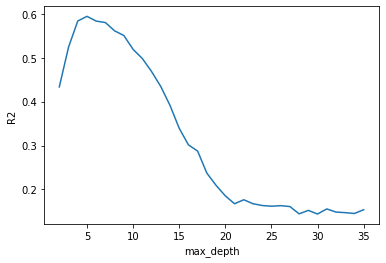

In [35]:
# Plot scores
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');


In [36]:
# Sort by test score
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.594702,0.603933
4,0.584005,0.582625
6,0.583894,0.614827
7,0.580508,0.626649
8,0.561593,0.644488


In [37]:
# creating my optimized tree
dc_tree_o = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dc_pipe_o = make_pipeline(preprocessor, dc_tree_o)
dc_pipe_o.fit(X_train, y_train)
train_9_score = dc_pipe_o.score(X_train, y_train)
test_9_score = dc_pipe_o.score(X_test, y_test)
print(train_9_score)
print(test_9_score)

0.6039330279227335
0.5947024005843626


In [38]:
# using function get scores for data
modtics(dc_pipe_o, X_train, y_train, X_test, y_test, model_name='Decision Tree')

Training scores for Decision Tree
R2: 0.604 
RMSE: 1,082.66 
Testing scores for Decision Tree
R2: 0.595 
RMSE: 1,057.45 


After using both models above (linear regression and the decision tree). I would recommend the decision tree due to the better performance on testing data.